In [1]:
import copy
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Regularization

In [2]:
np.random.seed(2346)

In [3]:
xs = np.linspace(-np.pi, np.pi,500)

In [4]:
rxs = np.random.uniform(-np.pi, np.pi,500)
rys = np.cos(rxs)+np.random.normal(0,.1,500)

In [5]:
data =np.stack((rxs, rys),1)

In [6]:
train_data_indices = np.random.choice(len(data),48,replace=False)
train_data = data[train_data_indices]

In [7]:
validation_data_indices = np.random.choice(len(data),24,replace=False)
validation_data = data[validation_data_indices]

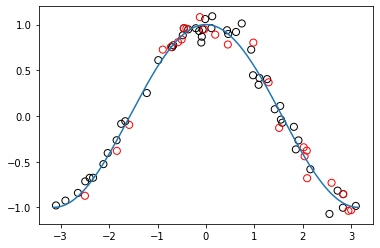

In [8]:
plt.scatter(train_data[:,0], train_data[:,1],s=50, edgecolors='black', facecolors='none');
plt.scatter(validation_data[:,0], validation_data[:,1], s=50,edgecolors='red', facecolors='none');
plt.plot(xs, np.cos(xs));

In [9]:
train_data_t = torch.from_numpy(train_data).to(dtype=torch.float32)
validation_data_t = torch.from_numpy(validation_data).to(dtype=torch.float32)

In [10]:
model = nn.Sequential(
    nn.Linear(1,128),nn.ReLU(),
    nn.Linear(128,64),nn.ReLU(),
    nn.Linear(64,1)
)

In [11]:
loss_f = nn.MSELoss()

In [12]:
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [13]:
%%time
errs=[]
n_epochs =8000
for e in range(n_epochs):
    opt.zero_grad()
    pred = model(train_data_t[:,0].view(-1,1))
    loss = loss_f(pred, train_data_t[:,1].view(-1,1))
    loss.backward()
    opt.step()
    with torch.no_grad():
        validation_pred = model(validation_data_t[:,0].view(-1,1))
        validation_loss = loss_f(validation_pred, validation_data_t[:,1].view(-1,1))
    errs.append((loss.item(), validation_loss.item()))    
print(loss.item())   
errors= np.asanyarray(errs)

0.003714668797329068
CPU times: user 1min 12s, sys: 1.01 s, total: 1min 13s
Wall time: 6.82 s


In [14]:
errors.min(0)

array([0.00371467, 0.01224985])

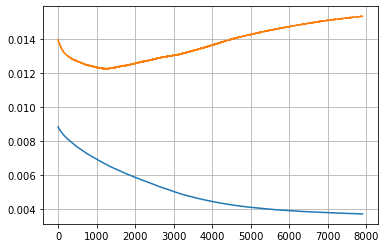

In [15]:
skip = 100
plt.plot(errors[skip:,0])
plt.plot(errors[skip:,1]);
plt.grid();

# Regularization

> Regularization is any modification we make to a learning algorithm that is intended  to reduce its generalization error but not its training error. 

## Early stopping

In [16]:
model = nn.Sequential(
    nn.Linear(1,128),nn.ReLU(),
    nn.Linear(128,64),nn.ReLU(),
    nn.Linear(64,1)
)

In [17]:
loss_f = nn.MSELoss()

In [18]:
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [19]:
min_model=None
min_validation_loss = 10000.0
min_e = None

In [20]:
%%time
errs=[]
n_epochs =8000
for e in range(n_epochs):
    opt.zero_grad()
    pred = model(train_data_t[:,0].view(-1,1))
    loss = loss_f(pred, train_data_t[:,1].view(-1,1))
    loss.backward()
    opt.step()
    with torch.no_grad():
        validation_pred = model(validation_data_t[:,0].view(-1,1))
        validation_loss = loss_f(validation_pred, validation_data_t[:,1].view(-1,1))
        vloss = validation_loss.item()
        if  vloss  <min_validation_loss:
            min_validation_loss = vloss
            e_min=e
            min_model = copy.deepcopy(model)
    errs.append((loss.item(), validation_loss.item()))    
print(loss.item())   
errors= np.asanyarray(errs)

0.003787171794101596
CPU times: user 1min 17s, sys: 4.7 s, total: 1min 22s
Wall time: 8.32 s


In [21]:
errors.min(0)

array([0.0037856 , 0.01214211])

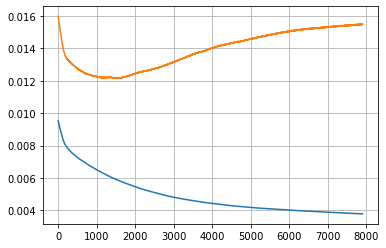

In [22]:
skip = 100
plt.plot(errors[skip:,0])
plt.plot(errors[skip:,1]);
plt.grid();

In [23]:
xs_t = torch.linspace(-np.pi, np.pi,200)

In [24]:
with torch.no_grad():
    ys_t = model(xs_t.view(-1,1)).view(-1)
    ys_min_t = min_model(xs_t.view(-1,1)).view(-1)

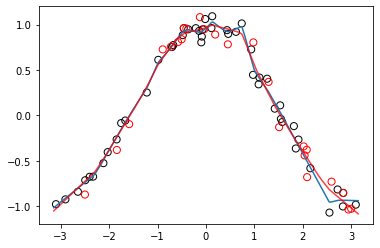

In [25]:
plt.plot(xs_t.numpy(), ys_t.numpy());
plt.plot(xs_t.numpy(), ys_min_t.numpy(), c='red', alpha=0.75);
plt.scatter(train_data[:,0], train_data[:,1],s=50, edgecolors='black', facecolors='none');
plt.scatter(validation_data[:,0], validation_data[:,1], s=50,edgecolors='red', facecolors='none');

In [26]:
class Experiment:
    def __init__(self):
        self.min_model=None
        self.min_validation_loss = 10000.0
        self.min_e = None
        

    def run(self, model,optim,n_epochs,  train, validation, loss_f = nn.MSELoss() ):
        errs = []
        for e in range(n_epochs):
            optim.zero_grad()
            pred = model(train[:,0].view(-1,1))
            loss = loss_f(pred, train[:,1].view(-1,1))
            loss.backward()
            optim.step()
            with torch.no_grad():
                model.eval()
                validation_pred = model(validation[:,0].view(-1,1))
                validation_loss = loss_f(validation_pred, validation[:,1].view(-1,1))
                vloss = validation_loss.item()
            if  vloss  <self.min_validation_loss:
                self.min_validation_loss = vloss
                self.min_e = e
                self.min_model = copy.deepcopy(model)
            model.train()    
            errs.append((loss.item(), validation_loss.item()))    
        errors= np.asanyarray(errs)
        return errors, min_model

## Weight decay

$$L(\theta|x,y)+\alpha \frac{1}{2}||\theta||^2$$ 

$$\nabla_\theta L(\theta|x,y) +\alpha\cdot  \theta$$

In [27]:
model_wd = nn.Sequential(
    nn.Linear(1,128),nn.ReLU(),
    nn.Linear(128,64),nn.ReLU(),
    nn.Linear(64,1)
)

In [28]:
loss_f = nn.MSELoss()

In [29]:
opt_wd = torch.optim.SGD(model_wd.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [30]:
wd_experiment = Experiment()

In [31]:
%%time
errors_wd, min_model_wd = wd_experiment.run(model_wd, opt_wd,8000, train_data_t, validation_data_t)

CPU times: user 1min 31s, sys: 3.93 s, total: 1min 35s
Wall time: 9.33 s


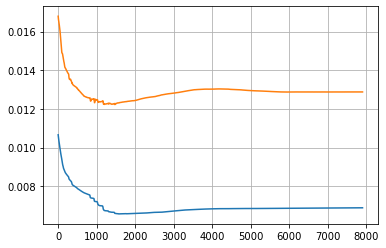

In [32]:
skip = 100
plt.plot(errors_wd[skip:,0])
plt.plot(errors_wd[skip:,1]);
plt.grid();

In [33]:
errors_wd.min(0)

array([0.00656182, 0.01222354])

In [34]:
xs_t = torch.linspace(-np.pi, np.pi,200)

In [35]:
with torch.no_grad():
    ys_t = model_wd(xs_t.view(-1,1)).view(-1)
    ys_min_t = min_model_wd(xs_t.view(-1,1)).view(-1)

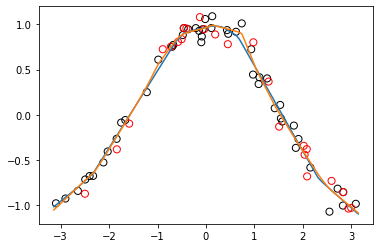

In [36]:
plt.plot(xs_t.numpy(), ys_t.numpy());
plt.plot(xs_t.numpy(), ys_min_t.numpy());
plt.scatter(train_data[:,0], train_data[:,1],s=50, edgecolors='black', facecolors='none');
plt.scatter(validation_data[:,0], validation_data[:,1], s=50,edgecolors='red', facecolors='none');

## Bagging 

In [37]:
def random_choice(data):
    perm = np.random.choice(len(data), len(data),replace=True)
    return data[perm]

In [38]:
n_bags = 10

In [39]:
bag = [random_choice(train_data_t) for  i in range(n_bags)]

In [40]:
models_bag  = [nn.Sequential(
    nn.Linear(1,128),nn.ReLU(),
    nn.Linear(128,64),nn.ReLU(),
    nn.Linear(64,1))  for i in range(n_bags) ]

In [41]:
dp_experiment = Experiment()

In [42]:
for i in range(n_bags):
    print(i)
    m = models_bag[i]
    data = bag[i]
    opt_bag = torch.optim.SGD(m.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0)
    errors_bag, min_model_bag = dp_experiment.run(m, opt_bag, 8000, data, validation_data_t)

0
1
2
3
4
5
6
7
8
9


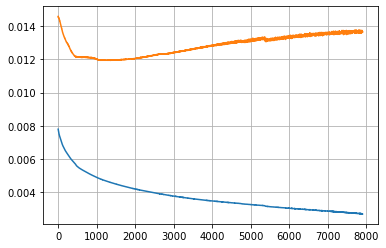

In [43]:
skip = 100
plt.plot(errors_bag[skip:,0])
plt.plot(errors_bag[skip:,1]);
plt.grid();

In [44]:
xs_t = torch.linspace(-np.pi, np.pi,200)

In [45]:
bag_loss =0.0
with torch.no_grad():
    pred = torch.zeros(len(validation_data_t))
    for m in models_bag:
        out =  m(validation_data_t[:,0].view(-1,1)).view(-1)
        print(loss_f(out, validation_data_t[:,1]).item())
        pred += out
pred/=n_bags
print(loss_f(pred, validation_data_t[:,1]).item())

0.01521348487585783
0.022718025371432304
0.017825044691562653
0.018935460597276688
0.015307259745895863
0.014828573912382126
0.014397207647562027
0.015782581642270088
0.012727371416985989
0.013669881038367748
0.014527582563459873


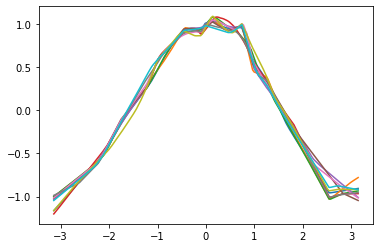

In [46]:
ys_t= torch.zeros_like(xs_t)
with torch.no_grad():
    for m in models_bag:
        out = m(xs_t.view(-1,1)).view(-1)
        plt.plot(xs_t.numpy(), out.numpy())
        ys_t +=out
    ys_t/=10.0    

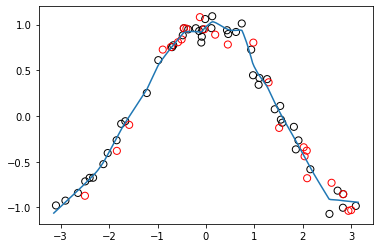

In [47]:
plt.plot(xs_t.numpy(), ys_t.numpy());
#plt.plot(xs_t.numpy(), ys_min_t.numpy());
plt.scatter(train_data[:,0], train_data[:,1],s=50, edgecolors='black', facecolors='none');
plt.scatter(validation_data[:,0], validation_data[:,1], s=50,edgecolors='red', facecolors='none');

## Dropout

![](dropout.png)

In [48]:
model_dp = nn.Sequential(
    nn.Linear(1,128),nn.ReLU(),nn.Dropout(0.25),
    nn.Linear(128,64),nn.ReLU(),nn.Dropout(0.25),
    nn.Linear(64,1)
)

In [49]:
opt_dp = torch.optim.SGD(model_dp.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0)

In [50]:
dp_experiment = Experiment()

In [51]:
%%time
model_dp.train()
errors_dp, min_model_dp = dp_experiment.run(model_dp, opt_dp, 8000, train_data_t, validation_data_t)

CPU times: user 1min 39s, sys: 1.88 s, total: 1min 41s
Wall time: 9.47 s


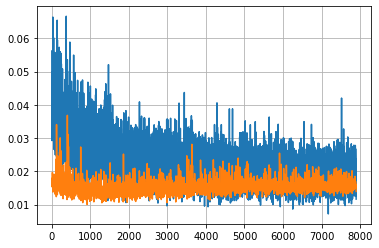

In [52]:
skip = 100
plt.plot(errors_dp[skip:,0])
plt.plot(errors_dp[skip:,1]);
plt.grid();

In [53]:
errors_dp.min(0)

array([0.00721424, 0.01005792])

In [54]:
xs_t = torch.linspace(-np.pi, np.pi,200)

In [55]:
with torch.no_grad():
    model_dp.eval()
    min_model_dp.eval()
    ys_t = model_dp(xs_t.view(-1,1)).view(-1)
    ys_min_t = min_model_dp(xs_t.view(-1,1)).view(-1)

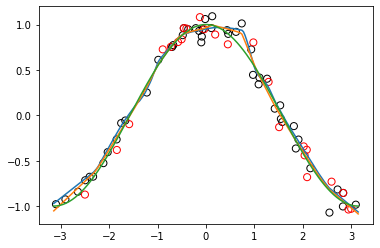

In [56]:
plt.plot(xs_t.numpy(), ys_t.numpy());
plt.plot(xs_t.numpy(), ys_min_t.numpy());
plt.plot(xs_t.numpy(), np.cos(xs_t.numpy()))
plt.scatter(train_data[:,0], train_data[:,1],s=50, edgecolors='black', facecolors='none');
plt.scatter(validation_data[:,0], validation_data[:,1], s=50,edgecolors='red', facecolors='none');